# Simulated Data for Brian Kirz's CS-282 Final Project
First I load the necssary packages and double check key packages versions.

In [7]:
# Import packages.
import demes
import demesdraw
from IPython.display import display, SVG
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
import tskit
# Print versions of our libraries.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('tskit', tskit.__version__)

demes 0.2.1
demesdraw 0.3.0
msprime 1.1.1
tskit 0.4.1


If the output of the above cell doesn't match `demes 0.2.1`, `demesdraw 0.3.0`, `msprime 1.1.1`, and `tskit 0.4.1` then this notebook will throw you one million error messages. I will now define two general functions, that I will need for the rest of this notebook.

## Model Sanity Check
Next I will use the same model as described in Fang et al. 2022 and validate it using `msprime` and `demes`.

In [8]:
# Define IUA model of introgression.
def iua_human_model(f):
    # Intialize demographic model.
    iua_model = msprime.Demography()
    # We assume constant and equal effective population sizes for
    # all lineages.
    iua_model.add_population(name='AFR', initial_size=10_000)
    iua_model.add_population(name='EUR', initial_size=10_000)
    iua_model.add_population(name='NEA', initial_size=10_000)
    iua_model.add_population(name='OUT', initial_size=10_000)
    iua_model.add_population(name='AMH', initial_size=10_000)
    iua_model.add_population(name='HUM', initial_size=10_000)
    iua_model.add_population(name='ANC', initial_size=10_000)
    # Introgression from the Neanderthal to the Eurasian lineage
    # occuring 4,000 generations ago with a probability of f.
    iua_model.add_mass_migration(
        time=4_000, source='EUR', dest='NEA', proportion=f,
    )
    # The African and Eurasian lineages merge into the anatomically
    # modern human lineage 16,000 generations ago.
    iua_model.add_population_split(
        time=16_000, derived=['AFR', 'EUR'], ancestral='AMH',
    )
    # The anatomically modern human and Neanderthal lineages merge
    # into the ancestral human lineage 20,000 generations ago.
    iua_model.add_population_split(
        time=20_000, derived=['AMH', 'NEA'], ancestral='HUM',
    )
    # The ancestral human and outgroup lineages merge
    # into the ancestral lineage 800,000 generations ago.
    iua_model.add_population_split(
        time=800_000, derived=['HUM', 'OUT'], ancestral='ANC',
    )
    return iua_model
# Sanity check to make sure the model is right.
test_model = iua_human_model(0.03)
test_model.debug()

Looks good but lets visualize this model as a sanity check.

<AxesSubplot:ylabel='time ago (generations)'>

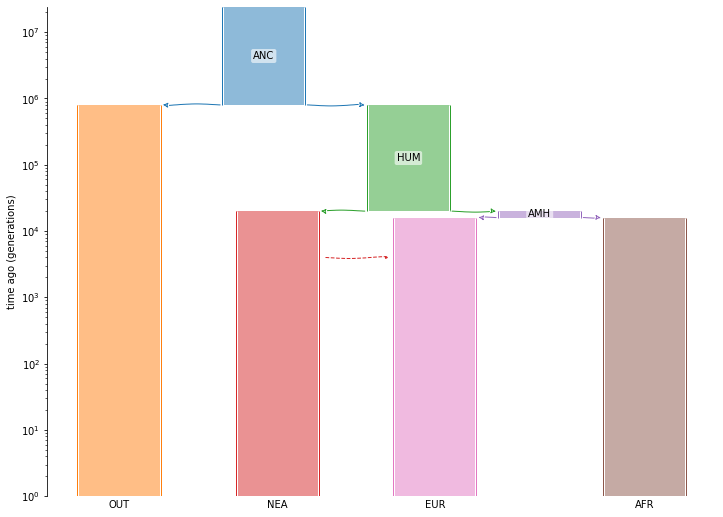

In [9]:
# Convert the demographic object to a demes graph.
test_graph = msprime.Demography.to_demes(test_model)
# Visualize the demes graph.
fig, ax = plt.subplots(figsize=(12,9))
demesdraw.tubes(test_graph, ax=ax, log_time=True)

## Example Simulation
Here I will walk through a simulation using the `iua_human_model()` function we defined earlier.

In [10]:
# Simulate a tree sequence.
ex_ts_f_03 = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(2, ploidy=1, population='AFR'), # Sample two haplotypes from AFR for our HMM.
        msprime.SampleSet(1, ploidy=1, population='EUR'),
        msprime.SampleSet(1, ploidy=1, population='NEA'),
        msprime.SampleSet(1, ploidy=1, population='OUT'),
    ],
    demography=iua_human_model(0.03), # Rate of introgression at 0.03.
    sequence_length=20_000_000, # Generate 20 Mb haplotypes per samples.
    recombination_rate=1e-8,
    record_migrations=True, # Need this to keep track of what segments are introgressed.
    discrete_genome=False,
    random_seed=42,
)
# Overlay mutations.
ex_mts_f_03 = msprime.sim_mutations(
    tree_sequence=ex_ts_f_03, rate=1.5e-8,
    model='jc69', random_seed=42,
    discrete_genome=False,
)
# View the mutated tree-sequence summary.
ex_mts_f_03

Ok so now we will look at the genotype matrix, where the first two indicies (i.e., 0 and 1) are the two `AFR` haplotypes, the third index (i.e., 2) is the `EUR` haplotype, the fourth index (i.e., 3) is the `NEA` haplotype, and the last index (i.e., -1) is the `OUT` haplotype.

In [11]:
# View the genotype matrix.
ex_raw_genotype_matrix = ex_mts_f_03.genotype_matrix()
print(ex_raw_genotype_matrix)
print('There are {0} variants between 5 unpolarized haplotypes of 20 Mb'.format(ex_raw_genotype_matrix.shape[0]))

[[1 1 1 1 0]
 [1 1 1 1 0]
 [0 0 0 0 1]
 ...
 [1 1 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
There are 516940 variants between 5 unpolarized haplotypes of 20 Mb


Next lets just run another sanity check to make sure there are that many positions.

In [12]:
# Grab the positions of the variable sites.
ex_variable_positions = ex_mts_f_03.tables.sites.position
print(ex_variable_positions)
print('There are {0} variants between 5 unpolarized haplotypes of 20 Mb'.format(ex_variable_positions.shape[0]))

[2.15364873e+01 3.33508083e+01 9.18967648e+01 ... 1.99999002e+07
 1.99999936e+07 1.99999967e+07]
There are 516940 variants between 5 unpolarized haplotypes of 20 Mb


For our purposes we will need the polarize our haplotypes such that our outgroup haplotype is always 0, but no need to fear I will include a function on how to do so.

In [13]:
# Define a function to polarize a genotype matrix.
def polarize_genotype_matrix(
    genotype_matrix,
):
    """
    ###########################################################################
    INPUT
        genotype_matrix: Simulated genotypes from msprime.
    ---------------------------------------------------------------------------
    OUTPUT: Polarized genotype matrix where the outgroup always harbors the
            ancestral allele.
    ###########################################################################
    """
    # Polarize the genotype matrix such that the outgroup taxon is always 0.
    polarize = lambda x: abs(x - 1)
    polarized_genotype_list = [polarize(site) if site[-1] == 1 else site for site in genotype_matrix]
    polarized_genotype_matrix = np.asarray(polarized_genotype_list)
    return polarized_genotype_matrix
# Polarize the example genotype matrix.
ex_polarized_genotype_matrix = polarize_genotype_matrix(ex_raw_genotype_matrix)
print(ex_polarized_genotype_matrix)

[[1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 0]
 ...
 [1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 0]]


So now we need to find the start and stop positions of the introgressed segments, to do so we will parse the migrations table and extract the left (start) and right (stop) positions for all introgression trees—i.e., the `dest` is from the `NEA` population (2) which occured 4000 generations ago (the time of introgression).

In [14]:
# Intilaize the start and stop lists.
ex_starts = []
ex_stops = []
# Parse through all migration events and record the start and stop positions for introgressed regions.
for migration in ex_mts_f_03.migrations():
    if (migration.dest == 2) and (migration.time == float(4000)):
        ex_starts.append(migration.left)
        ex_stops.append(migration.right)
# Print a summary.
print('Start positions of introgressed regions: {0}'.format(ex_starts))
print('Stop positions of introgressed regions: {0}'.format(ex_starts))

Start positions of introgressed regions: [8140010.720961671, 8386088.554532683, 1448351.361984973, 2568334.2587925983, 233591.6468729049, 15527390.13840136, 4253073.412968563, 10434970.242597777, 16731242.807630714, 16967605.690655127, 19898089.55145829, 19426282.58320637, 11761718.294151794, 17951326.091634862, 260518.3202967598, 437440.6151562037, 17634818.185162324, 19572106.19887641]
Stop positions of introgressed regions: [8140010.720961671, 8386088.554532683, 1448351.361984973, 2568334.2587925983, 233591.6468729049, 15527390.13840136, 4253073.412968563, 10434970.242597777, 16731242.807630714, 16967605.690655127, 19898089.55145829, 19426282.58320637, 11761718.294151794, 17951326.091634862, 260518.3202967598, 437440.6151562037, 17634818.185162324, 19572106.19887641]


Now lets run one last sanity check by checking the actual migration table.

In [15]:
# Print the number of start and stop positions for introgressed regions.
print('There are {0} start and {1} stop positions for introgressed regions.'.format(len(ex_starts), len(ex_stops)))
# Print out the migration table.
ex_mts_f_03.tables.migrations

There are 18 start and 18 stop positions for introgressed regions.


id,left,right,node,source,dest,time,metadata
0,8140010.72096167,8142714.79592562,2,1,2,4000.00000000,b''
1,8386088.55453268,8400125.26909963,2,1,2,4000.00000000,b''
2,1448351.36198497,1463190.82120507,2,1,2,4000.00000000,b''
3,2568334.25879260,2689267.70426328,2,1,2,4000.00000000,b''
4,233591.64687290,260518.32029676,2,1,2,4000.00000000,b''
5,15527390.13840136,15561168.45830450,2,1,2,4000.00000000,b''
6,4253073.41296856,4259518.31279358,2,1,2,4000.00000000,b''
7,10434970.24259778,10463509.05945915,2,1,2,4000.00000000,b''
8,16731242.80763071,16803926.48858202,2,1,2,4000.00000000,b''
9,16967605.69065513,16974004.34731545,2,1,2,4000.00000000,b''


Since all of our sanity checks look good lets generate this data!

## Generating Simulated Data Sanity Checks
First I will just come up with a toy example, do a sanity check, and then actually explain everything.

In [16]:
# For 1 replicate.
for rep in list(range(1, 2)):
    # Simulate a tree sequence.
    ts_f_03 = msprime.sim_ancestry(
        samples=[
            msprime.SampleSet(2, ploidy=1, population='AFR'), # Sample two haplotypes from AFR for our HMM.
            msprime.SampleSet(1, ploidy=1, population='EUR'),
            msprime.SampleSet(1, ploidy=1, population='NEA'),
            msprime.SampleSet(1, ploidy=1, population='OUT'),
        ],
        demography=iua_human_model(0.03), # Rate of introgression at 0.03.
        sequence_length=20_000_000, # Generate 20 Mb haplotypes per samples.
        recombination_rate=1e-8,
        record_migrations=True, # Need this to keep track of what segments are introgressed.
        discrete_genome=False,
        random_seed=rep,
    )
    # Overlay mutations.
    mts_f_03 = msprime.sim_mutations(
        tree_sequence=ex_ts_f_03, rate=1.5e-8,
        model='jc69', random_seed=rep,
        discrete_genome=False,
    )
    # Extract the genotype matrix.
    unpolarized_genotype_matrix = mts_f_03.genotype_matrix()
    # Polarize the genotype matrix.
    polarized_genotype_matrix = polarize_genotype_matrix(unpolarized_genotype_matrix)
    # Save the genotype matrix.
    np.savetxt(
        './cs282_sim_data/rep_id_{0}_polarized_geno_mat.csv.gz'.format(rep),
        polarized_genotype_matrix,
        fmt='%d',
        delimiter=',',
        )
    # Extract the variable positions.
    variable_positions = mts_f_03.tables.sites.position
    # Save the variable positions.
    np.savetxt(
        './cs282_sim_data/rep_id_{0}_var_pos.csv.gz'.format(rep),
        [variable_positions],
        fmt='%1.15f',
        delimiter=',',
        newline='\n',
    )
    # Extract the start and stop positions for introgressed regions.
    intro_starts = []
    intro_stops = []
    # Parse through all migration events and record the start and stop positions for introgressed regions.
    for migration in mts_f_03.migrations():
        if (migration.dest == 2) and (migration.time == float(4000)):
            intro_starts.append(migration.left)
            intro_stops.append(migration.right)
    # Construct and output a pandas dataframe. 
    intro_regions_df = pd.DataFrame({
        'start': intro_starts,
        'stop': intro_stops,
    })
    # Save the pandas dataframe.
    intro_regions_df.to_csv(
        path_or_buf='./cs282_sim_data/rep_id_{0}_intro_pos.csv.gz'.format(rep),
        sep=',',
        float_format='%1.15f',
        index=False,
    )
    # Save the tree-sequence just for good measures.
    mts_f_03.dump('./cs282_sim_data/rep_id_{0}_mut_tree_seq.ts'.format(rep))
    # Progress Checker
    print('Finished simulating rep {0}!'.format(rep))

Finished simulating rep 1!


Cool cool cool, now lets just run one last sanity check.

In [17]:
# Load the mutated tree sequence.
rep_id_1_mts = tskit.load('./cs282_sim_data/rep_id_1_mut_tree_seq.ts')
# Load the variable positions.
rep_id_1_var_pos = np.loadtxt('./cs282_sim_data/rep_id_1_var_pos.csv.gz', delimiter=',')
# Load the genotype matrix.
rep_id_1_polarized_geno_mat = np.loadtxt('./cs282_sim_data/rep_id_1_polarized_geno_mat.csv.gz', dtype=int, delimiter=',')
# Load the introgressed region dataframe.
rep_id_1_intro_pos_df = pd.read_csv('./cs282_sim_data/rep_id_1_intro_pos.csv.gz', float_precision='round_trip')
# Inspect the tree-sequence summary.
rep_id_1_mts

In [18]:
# Check to see if the variable positions and polarize genotype matricies are identical.
var_pos_check = np.array_equal(rep_id_1_var_pos, rep_id_1_mts.tables.sites.position)
geno_mat_check = np.array_equal(rep_id_1_polarized_geno_mat, polarize_genotype_matrix(rep_id_1_mts.genotype_matrix()))
# Print the sanity check.
print('It is {0} that the variable positions are the same and {1} that the polarized genotype matrices are the same.'.format(var_pos_check, geno_mat_check))

It is True that the variable positions are the same and True that the polarized genotype matrices are the same.


Lastly lets inspect that introgressed regions are correct.

In [19]:
# Exported table.
rep_id_1_intro_pos_df

,start,stop
0,8.140011e+06,8.142715e+06
1,8.386089e+06,8.400125e+06
2,1.448351e+06,1.463191e+06
3,2.568334e+06,2.689268e+06
4,2.335916e+05,2.605183e+05
5,1.552739e+07,1.556117e+07
6,4.253073e+06,4.259518e+06
7,1.043497e+07,1.046351e+07
8,1.673124e+07,1.680393e+07
9,1.696761e+07,1.697400e+07


In [20]:
# Full mutation table.
rep_id_1_mts.tables.migrations

id,left,right,node,source,dest,time,metadata
0,8140010.72096167,8142714.79592562,2,1,2,4000.00000000,b''
1,8386088.55453268,8400125.26909963,2,1,2,4000.00000000,b''
2,1448351.36198497,1463190.82120507,2,1,2,4000.00000000,b''
3,2568334.25879260,2689267.70426328,2,1,2,4000.00000000,b''
4,233591.64687290,260518.32029676,2,1,2,4000.00000000,b''
5,15527390.13840136,15561168.45830450,2,1,2,4000.00000000,b''
6,4253073.41296856,4259518.31279358,2,1,2,4000.00000000,b''
7,10434970.24259778,10463509.05945915,2,1,2,4000.00000000,b''
8,16731242.80763071,16803926.48858202,2,1,2,4000.00000000,b''
9,16967605.69065513,16974004.34731545,2,1,2,4000.00000000,b''


Great! Now that all sanity checks are complete lets generate this data for Brian!

## Data for Brian
Here I simulate and export the following information to the `cs282_sim_data` directory:  
`rep_id_{REP}_polarized_geno_mat.csv.gz` - polarized genotype matrix  
`rep_id_{REP}_var_pos.csv.gz` - array of all variable positions  
`rep_id_{REP}_intro_pos.csv.gz` - dataframe of start and stop positions for introgressed regions  
`rep_id_{REP}_mut_tree_seq.ts` - the complete tree-sequence for the replicate

In [67]:
# For 100 replicates.
for rep in list(range(1, 101)):
    # Simulate a tree sequence.
    ts_f_03 = msprime.sim_ancestry(
        samples=[
            msprime.SampleSet(2, ploidy=1, population='AFR'), # Sample two haplotypes from AFR for our HMM.
            msprime.SampleSet(1, ploidy=1, population='EUR'),
            msprime.SampleSet(1, ploidy=1, population='NEA'),
            msprime.SampleSet(1, ploidy=1, population='OUT'),
        ],
        demography=iua_human_model(0.03), # Rate of introgression at 0.03.
        sequence_length=20_000_000, # Generate 20 Mb haplotypes per samples.
        recombination_rate=1e-8,
        record_migrations=True, # Need this to keep track of what segments are introgressed.
        discrete_genome=False,
        random_seed=rep,
    )
    # Overlay mutations.
    mts_f_03 = msprime.sim_mutations(
        tree_sequence=ex_ts_f_03, rate=1.5e-8,
        model='jc69', random_seed=rep,
        discrete_genome=False,
    )
    # Extract the genotype matrix.
    unpolarized_genotype_matrix = mts_f_03.genotype_matrix()
    # Polarize the genotype matrix.
    polarized_genotype_matrix = polarize_genotype_matrix(unpolarized_genotype_matrix)
    # Save the genotype matrix.
    np.savetxt(
        './cs282_sim_data/rep_id_{0}_polarized_geno_mat.csv.gz'.format(rep),
        polarized_genotype_matrix,
        fmt='%d',
        delimiter=',',
        )
    # Extract the variable positions.
    variable_positions = mts_f_03.tables.sites.position
    # Save the variable positions.
    np.savetxt(
        './cs282_sim_data/rep_id_{0}_var_pos.csv.gz'.format(rep),
        [variable_positions],
        fmt='%1.15f',
        delimiter=',',
        newline='\n',
    )
    # Extract the start and stop positions for introgressed regions.
    intro_starts = []
    intro_stops = []
    # Parse through all migration events and record the start and stop positions for introgressed regions.
    for migration in mts_f_03.migrations():
        if (migration.dest == 2) and (migration.time == float(4000)):
            intro_starts.append(migration.left)
            intro_stops.append(migration.right)
    # Construct and output a pandas dataframe. 
    intro_regions_df = pd.DataFrame({
        'start': intro_starts,
        'stop': intro_stops,
    })
    # Save the pandas dataframe.
    intro_regions_df.to_csv(
        path_or_buf='./cs282_sim_data/rep_id_{0}_intro_pos.csv.gz'.format(rep),
        sep=',',
        float_format='%1.15f',
        index=False,
    )
    # Save the tree-sequence just for good measures.
    mts_f_03.dump('./cs282_sim_data/rep_id_{0}_mut_tree_seq.ts'.format(rep))
    # Progress Checker
    print('Finished simulating rep {0}!'.format(rep))

Finished simulating rep 1!
Finished simulating rep 2!
Finished simulating rep 3!
Finished simulating rep 4!
Finished simulating rep 5!
Finished simulating rep 6!
Finished simulating rep 7!
Finished simulating rep 8!
Finished simulating rep 9!
Finished simulating rep 10!
Finished simulating rep 11!
Finished simulating rep 12!
Finished simulating rep 13!
Finished simulating rep 14!
Finished simulating rep 15!
Finished simulating rep 16!
Finished simulating rep 17!
Finished simulating rep 18!
Finished simulating rep 19!
Finished simulating rep 20!
Finished simulating rep 21!
Finished simulating rep 22!
Finished simulating rep 23!
Finished simulating rep 24!
Finished simulating rep 25!
Finished simulating rep 26!
Finished simulating rep 27!
Finished simulating rep 28!
Finished simulating rep 29!
Finished simulating rep 30!
Finished simulating rep 31!
Finished simulating rep 32!
Finished simulating rep 33!
Finished simulating rep 34!
Finished simulating rep 35!
Finished simulating rep 36!
F